<a href="https://colab.research.google.com/github/ayushsingh2632003/SENTIMENT_analysis-using-RNN-LSTM-GRU-1DCNN/blob/main/Sentiment_analysis_with_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [2]:
BATCH_SIZE=64

In [3]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5FPX4T/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5FPX4T/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete5FPX4T/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
for review,label in val_ds.take(2):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

In [5]:
import re
import string
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output
    lowerc

In [6]:
standardization(tf.constant("<u>In the movie?, </u>man called Tévèz, went to a friend’s pl**ce and they had a tensed discussion. I don’t love this movie! would you?<br> <br /><br />T"))

<tf.Tensor: shape=(), dtype=string, numpy=b'in the movie man called t\xc3\xa9v\xc3\xa8z went to a friend\xe2\x80\x99s plce and they had a tensed discussion i don\xe2\x80\x99t love this movie would you t'>

In [7]:
from tensorflow.keras.layers import TextVectorization
VOCAB_SIZE=10000
SEQUENCE_LENGTH=250
EMBEDDING_DIM=300
vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [8]:
# lengths=[]
# words=[]

# for review,label in train_ds.take(10):
#   for word in tf.strings.split(review, sep=" "):
#     if word in words:
#       pass
#     else:
#       words.append(word)
#   lengths.append(len(tf.strings.split(review, sep=" ")))

In [9]:
# print(len(words))
# print(lengths)

In [10]:
training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)#### adapt the vectorize_layer to the training data

In [11]:
training_data

<_MapDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [12]:
len(vectorize_layer.get_vocabulary())

10000

In [13]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [14]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [15]:
vectorize_layer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'this',
 'i',
 'that',
 'was',
 'as',
 'with',
 'for',
 'movie',
 'but',
 'film',
 'on',
 'not',
 'are',
 'you',
 'his',
 'have',
 'be',
 'he',
 'one',
 'its',
 'at',
 'all',
 'by',
 'an',
 'they',
 'who',
 'from',
 'like',
 'so',
 'her',
 'or',
 'just',
 'about',
 'has',
 'out',
 'if',
 'some',
 'what',
 'there',
 'good',
 'more',
 'very',
 'when',
 'she',
 'even',
 'up',
 'no',
 'would',
 'my',
 'which',
 'only',
 'time',
 'really',
 'story',
 'their',
 'were',
 'had',
 'see',
 'can',
 'me',
 'than',
 'we',
 'much',
 'been',
 'get',
 'well',
 'will',
 'into',
 'because',
 'people',
 'other',
 'also',
 'do',
 'bad',
 'great',
 'how',
 'first',
 'most',
 'him',
 'dont',
 'made',
 'movies',
 'then',
 'films',
 'make',
 'could',
 'way',
 'them',
 'any',
 'too',
 'after',
 'characters',
 'think',
 'watch',
 'two',
 'many',
 'being',
 'seen',
 'character',
 'never',
 'little',
 'acting',
 'plot',
 'where',
 'best',
 '

In [16]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [17]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
import numpy as np
inputs=np.random.random([32, 100, 8]).astype(np.float32) #batch, sequence , voacab sizes
simple_rnn=tf.keras.layers.SimpleRNN(25) # output dimension
output=simple_rnn(inputs)
print(output.shape)

(32, 25)


In [19]:
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Sequential
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 643137 (2.45 MB)
Trainable params: 643137 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/rnn.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
from keras.callbacks import ModelCheckpoint

In [22]:

history=model.fit(
    train_dataset.take(10),
    validation_data=val_dataset.take(10),
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.4656

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 10s 670ms/step - loss: 0.7032 - accuracy: 0.4656 - val_loss: 0.6939 - val_accuracy: 0.5250
Epoch 2/10
10/10 [==============================] - 4s 406ms/step - loss: 0.6875 - accuracy: 0.5703 - val_loss: 0.6927 - val_accuracy: 0.5250
Epoch 3/10
10/10 [==============================] - 3s 263ms/step - loss: 0.6761 - accuracy: 0.6156 - val_loss: 0.6939 - val_accuracy: 0.5078
Epoch 4/10
10/10 [==============================] - 3s 265ms/step - loss: 0.6622 - accuracy: 0.6750 - val_loss: 0.6966 - val_accuracy: 0.4922
Epoch 5/10
10/10 [==============================] - 3s 292ms/step - loss: 0.6435 - accuracy: 0.7250 - val_loss: 0.6991 - val_accuracy: 0.4953
Epoch 6/10
10/10 [==============================] - 4s 374ms/step - loss: 0.6183 - accuracy: 0.7641 - val_loss: 0.7005 - val_accuracy: 0.4797
Epoch 7/10
10/10 [==============================] - 3s 262ms/step - loss: 0.5868 - accuracy: 0.8234 - val_loss: 0.7018 - val_accuracy: 0.4844
Epoch 8/10
10/10

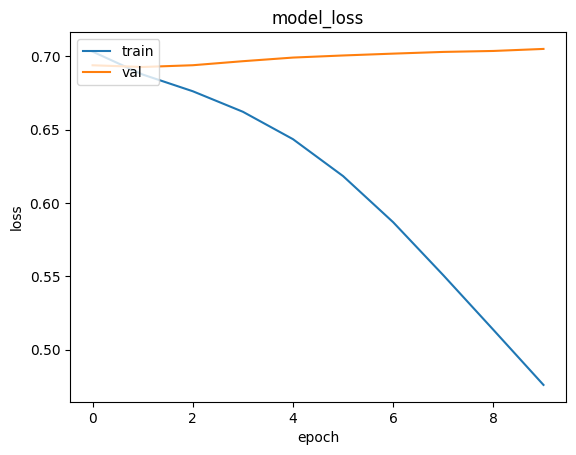

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

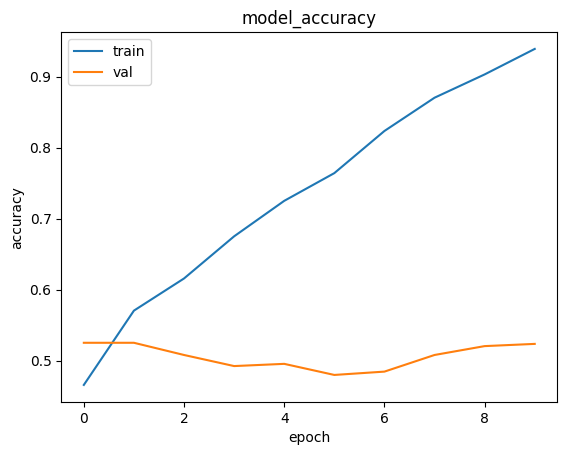

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)) ,
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    Bidirectional(LSTM(64,return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),

    ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 250, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [26]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [28]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 84s 188ms/step - loss: 0.6394 - accuracy: 0.6040 - val_loss: 0.4154 - val_accuracy: 0.8210
Epoch 2/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3357 - accuracy: 0.8647 - val_loss: 0.3600 - val_accuracy: 0.8519
Epoch 3/10
391/391 [==============================] - 24s 62ms/step - loss: 0.2467 - accuracy: 0.9092 - val_loss: 0.3919 - val_accuracy: 0.8542
Epoch 4/10
391/391 [==============================] - 28s 71ms/step - loss: 0.2038 - accuracy: 0.9299 - val_loss: 0.4231 - val_accuracy: 0.8513
Epoch 5/10
391/391 [==============================] - 22s 57ms/step - loss: 0.1834 - accuracy: 0.9390 - val_loss: 0.3855 - val_accuracy: 0.8548
Epoch 6/10
391/391 [==============================] - 27s 70ms/step - loss: 0.1527 - accuracy: 0.9515 - val_loss: 0.4416 - val_accuracy: 0.8512
Epoch 7/10
391/391 [==============================] - 24s 62ms/step - loss: 0.1331 - accuracy: 0.9602 - val_loss: 0.4838 - val_accuracy

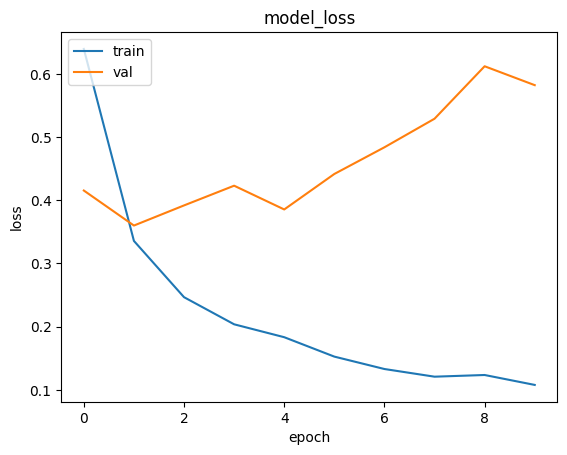

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

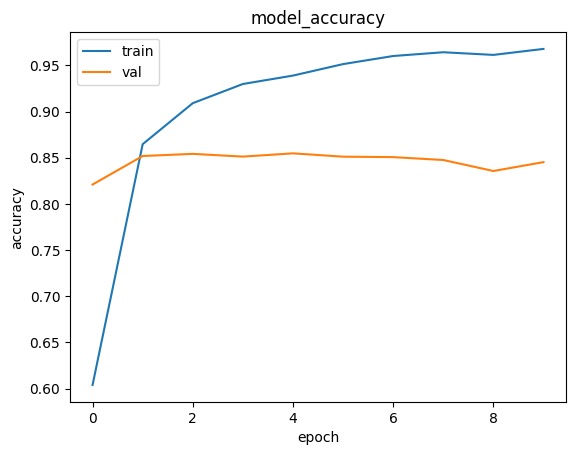

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 5s 26ms/step - loss: 0.5713 - accuracy: 0.8469


[0.571327805519104, 0.8468800187110901]

In [32]:
# GRU
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Bidirectional(GRU(64,return_sequences=True)),
    Bidirectional(GRU(32)),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 64)           640000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 250, 128)          49920     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                31104     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [33]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/gru.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [35]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[])

Epoch 1/10
391/391 [==============================] - 68s 147ms/step - loss: 0.6903 - accuracy: 0.5420 - val_loss: 0.6757 - val_accuracy: 0.6010
Epoch 2/10
391/391 [==============================] - 26s 65ms/step - loss: 0.4275 - accuracy: 0.8062 - val_loss: 0.3450 - val_accuracy: 0.8531
Epoch 3/10
391/391 [==============================] - 22s 56ms/step - loss: 0.2708 - accuracy: 0.8970 - val_loss: 0.3360 - val_accuracy: 0.8631
Epoch 4/10
391/391 [==============================] - 24s 60ms/step - loss: 0.2236 - accuracy: 0.9227 - val_loss: 0.3887 - val_accuracy: 0.8580
Epoch 5/10
391/391 [==============================] - 22s 56ms/step - loss: 0.1968 - accuracy: 0.9338 - val_loss: 0.4051 - val_accuracy: 0.8591
Epoch 6/10
391/391 [==============================] - 24s 62ms/step - loss: 0.1697 - accuracy: 0.9448 - val_loss: 0.4307 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 23s 59ms/step - loss: 0.1518 - accuracy: 0.9498 - val_loss: 0.4552 - val_accuracy

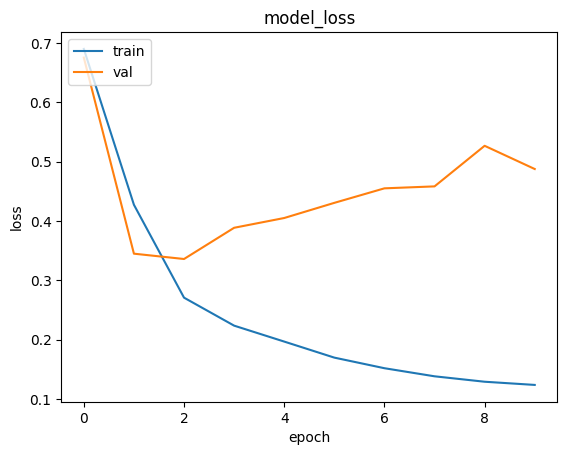

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

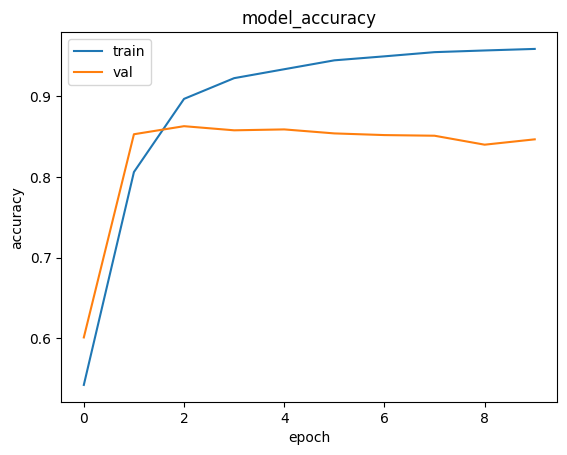

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [38]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 8s 39ms/step - loss: 0.4873 - accuracy: 0.8446


[0.4872594177722931, 0.8446400165557861]

In [39]:
# cnn 1d
EMBEDDING_DIM=300
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    Conv1D(32, 3, activation='relu',),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 248, 32)           28832     
                                                                 
 flatten (Flatten)           (None, 7936)              0         
                                                                 
 dense_5 (Dense)             (None, 32)                253984    
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3282849 (12.52 MB)
Trainable params: 328

In [40]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/sentiment_analysis/conv_1d.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [41]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [42]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[model_checkpoint_callback])

Epoch 1/10
391/391 [==============================] - 65s 158ms/step - loss: 0.6919 - accuracy: 0.5160 - val_loss: 0.6852 - val_accuracy: 0.5758


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
391/391 [==============================] - 11s 28ms/step - loss: 0.5211 - accuracy: 0.7489 - val_loss: 0.3517 - val_accuracy: 0.8540
Epoch 3/10
391/391 [==============================] - 12s 31ms/step - loss: 0.2853 - accuracy: 0.8883 - val_loss: 0.3095 - val_accuracy: 0.8703
Epoch 4/10
391/391 [==============================] - 14s 36ms/step - loss: 0.2142 - accuracy: 0.9226 - val_loss: 0.3175 - val_accuracy: 0.8655
Epoch 5/10
391/391 [==============================] - 12s 31ms/step - loss: 0.1685 - accuracy: 0.9440 - val_loss: 0.3419 - val_accuracy: 0.8624
Epoch 6/10
391/391 [==============================] - 13s 33ms/step - loss: 0.1392 - accuracy: 0.9553 - val_loss: 0.3711 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 12s 31ms/step - loss: 0.1143 - accuracy: 0.9670 - val_loss: 0.4065 - val_accuracy: 0.8550
Epoch 8/10
391/391 [==============================] - 15s 37ms/step - loss: 0.0931 - accuracy: 0.9744 - val_loss: 0.4488 - val_accuracy:

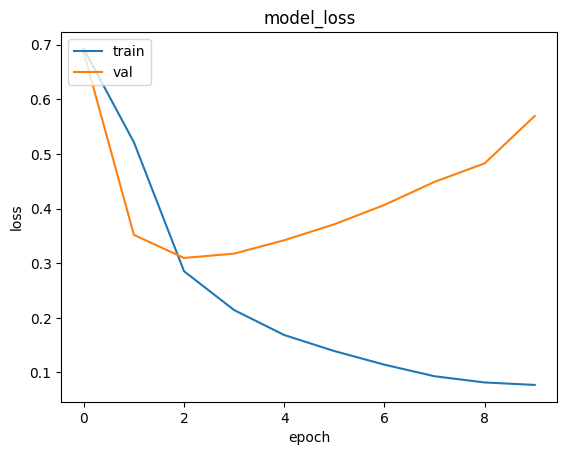

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

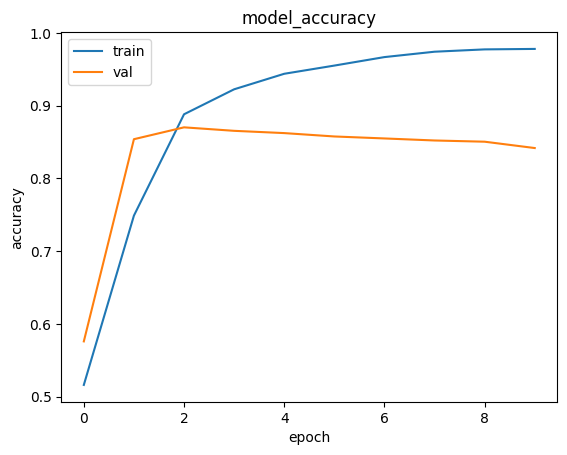

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
model.load_weights(checkpoint_filepath)

In [46]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 4s 18ms/step - loss: 0.3114 - accuracy: 0.8682


[0.31135451793670654, 0.8681600093841553]